In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement= Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.id, Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date.date)

2017-08-23


In [13]:
date1 = recent_date.date
date1 = dt.datetime.strptime(date1, '%Y-%m-%d').date()
date2 = date1 - dt.timedelta(days=365)
print(date1, date2) 

2017-08-23 2016-08-23


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date2).\
    order_by(Measurement.date.desc()).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns=['date', 'precipitation'])
prcp_df =prcp_df.dropna(subset=['precipitation'])
prcp_df.set_index('date', inplace=True)
prcp_df=prcp_df.sort_index()
prcp_df.head(10)

,precipitation
date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,0.02
2016-08-23,0.05
2016-08-24,1.45
2016-08-24,2.15
2016-08-24,1.22


In [15]:
#print(plt.style.available)

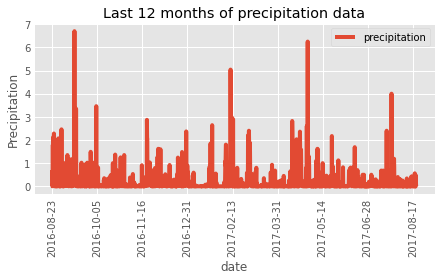

In [16]:
# Plot the dataframe as a horizontal bar chart using pandas plotting
plt.style.use('ggplot')
prcp_df.plot(title="Last 12 months of precipitation data",rot=90)
plt.tight_layout()
plt.ylabel("Precipitation")
plt.savefig("Output/precipitation.png")
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_statistics = prcp_df["precipitation"].describe()
summaryst_df = pd.DataFrame(summary_statistics)
summaryst_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
station_num = session.query(func.count(Station.id)).all()
print('The Total number stations in the dataset is:', station_num)

The Total number stations in the dataset is: [(9,)]


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_rows = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).\
            order_by(func.count(Measurement.date).desc()).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
station_df = pd.DataFrame(station_rows, columns=['station','count'])
print(station_df)
active_station = station_df.loc[0][0]
print("-------------------------------------------")
print('The Most Active Station is: ',active_station)

       station  count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511
-------------------------------------------
The Most Active Station is:  USC00519281


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sum_activestation = session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
            filter(Measurement.station == active_station).all()
summary_as=pd.DataFrame(sum_activestation, columns=['station','Min', 'Max', 'Avg'])
summary_as.set_index('station', inplace=True)
summary_as

,Min,Max,Avg
station,,,
USC00519281,54.0,85.0,71.663781


In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_activestation = session.query(Measurement.tobs).\
            filter(Measurement.station == active_station).\
            filter(Measurement.date >= date2).\
            order_by(Measurement.date.desc()).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
tempas_df = pd.DataFrame(temp_activestation, columns=['tobs'])
tempas_df=tempas_df.dropna(subset=['tobs'])
tempas_df.head(10)

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0
5,77.0
6,83.0
7,82.0
8,77.0
9,76.0


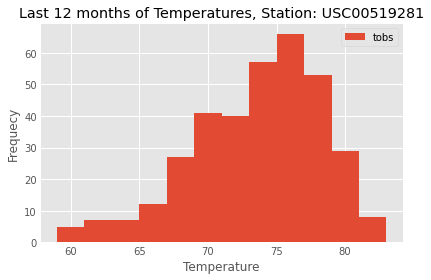

In [22]:
# Plot the dataframe as a horizontal bar chart using pandas plotting
tempas_df.plot.hist(bins=12)
plt.title("Last 12 months of Temperatures, Station: "+ active_station)
plt.ylabel("Frequecy")
plt.xlabel ("Temperature")
plt.tight_layout()
plt.savefig("Output/temperature.png")
plt.show()

# Close session

In [23]:
# Close Session
session.close()